### **Bioinformatics Project - Computational Drug Discovery [Part 2]** 

#### **Install conda and rdkit**
RDKit is a popular open-source cheminformatics software toolkit that is widely used by chemists, biologists, and other researchers in drug discovery, materials science, and other areas of chemistry. It provides a set of powerful and efficient tools for working with molecular structures, including molecules, reactions, and fragments.
RDKit is a powerful and versatile toolkit that provides a range of tools and capabilities for chemists and other researchers working with molecular structures. Its ease of use and broad range of applications have made it a popular choice for cheminformatics and drug discovery research.

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2023-04-20 08:06:02--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   175MB/s    in 0.5s    

2023-04-20 08:06:02 (175 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling=

### **Load bioactivity data**
Calculate descipater from canonical_smiles.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/acetylcholinesterase_bioactivity_data.csv')
df.head(3)

molecule_chembl_id                                   canonical_smiles  \
0       CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1       CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2       CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   

   standard_value     class  
0           750.0    active  
1           100.0    active  
2         50000.0  inactive

In [ ]:
df.shape

(3801, 4)

In [ ]:
df_no_smiles = df.drop(columns=['canonical_smiles'])

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest) 

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_smiles

molecule_chembl_id  standard_value     class  \
0          CHEMBL133897           750.0    active   
1          CHEMBL336398           100.0    active   
2          CHEMBL131588         50000.0  inactive   
3          CHEMBL130628           300.0    active   
4          CHEMBL130478           800.0    active   
...                 ...             ...       ...   
3796      CHEMBL3972214          3300.0    active   
3797      CHEMBL3910142            29.0    active   
3798         CHEMBL8706        500000.0    active   
3799          CHEMBL972        500000.0    active   
3800      CHEMBL3291019           350.0    active   

                                       canonical_smiles  
0                 CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1  
1            O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1  
2     CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1  
3         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F  
4             CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C  
...                                                 ...  
3796  C#CCN(Cc1ccc2cccc(O)c2n1)C(C#N)CC1CCN(Cc2ccccc...  
3797  C#CCN(Cc1ccc2cccc(O)c2n1)C(C#N)CCC1CCN(Cc2cccc...  
3798                         C#CCN(C)CCCOc1ccc(Cl)cc1Cl  
3799                          C#CCN(C)[C@H](C)Cc1ccccc1  
3800  C#CCN(Cc1ccc(O)c2ncccc12)C(C#N)CCC1CCN(Cc2cccc...  

[3801 rows x 4 columns]

### **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_smiles.canonical_smiles)
df_lipinski.sample(3)

MW     LogP  NumHDonors  NumHAcceptors
1810  544.692  7.29440         1.0            6.0
1640  313.401  3.35612         1.0            5.0
717   300.352  4.48130         1.0            2.0

In [ ]:
df_lipinski.shape

(3801, 4)

**Combine DataFrames**
Let's take a look at the 2 DataFrames that will be combined.
**df_smiles and df_lipinski**

In [ ]:
df_1 = pd.concat([df_smiles,df_lipinski],axis=1)
df_1.sample(3)

molecule_chembl_id  standard_value         class  \
796       CHEMBL1788306         11600.0        active   
3114      CHEMBL2391486            92.0  intermediate   
3748      CHEMBL3828631           125.0      inactive   

                                       canonical_smiles       MW     LogP  \
796             C#CCN[C@@H]1CCc2ccc(OC(=O)N(C)CCCC)cc21  300.402  3.12740   
3114  Cc1cc(=O)oc2cc(OCCN3CCN(CC(=O)Nc4c5c(nc6ccccc4...  526.637  4.16352   
3748  CN(CCCOc1ccc2cc(-c3ccccc3)c(=O)oc2c1)Cc1cccc(O...  604.747  7.86230   

      NumHDonors  NumHAcceptors  
796          1.0            3.0  
3114         1.0            7.0  
3748         1.0            6.0

In [ ]:
df_1.shape

(3801, 8)

### **Convert IC50 to pIC50**
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

* Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10
* Take the molar value and apply -log10
* Delete the standard_value column and create a new pIC50 column

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

# Apply after the norm_value function
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50 # Update ic50 to PIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [ ]:
df_1.standard_value.describe()

count    3.801000e+03
mean     1.246460e+05
std      1.135285e+06
min      6.000000e-03
25%      1.100000e+02
50%      1.900000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value, dtype: float64

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm # Normalize standard_value
    x = input.drop('standard_value', 1) # drop old standard_value column
        
    return x

In [ ]:
df_1 = norm_value(df_1)
df_1.sample(3)

<ipython-input-17-a8cb36b81d3d>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1) # drop old standard_value column


molecule_chembl_id         class  \
1229       CHEMBL241827        active   
2017      CHEMBL1243203  intermediate   
3541      CHEMBL3642049      inactive   

                                       canonical_smiles       MW    LogP  \
1229  COc1cc2oc(-c3ccc(CN(C)Cc4ccccc4)cc3)cc(=O)c2cc1OC  415.489  5.1092   
2017  CN1CC[C@@]2(C)c3cc(OC(=O)Nc4ccccc4)ccc3N(C=O)[...  351.406  3.1932   
3541  CC(=O)NCCc1c[nH]c2ccc(OC(=O)NCCCCCCCCNc3c4c(nc...  569.750  6.8146   

      NumHDonors  NumHAcceptors  standard_value_norm  
1229         0.0            5.0              3100.00  
2017         1.0            4.0               330.00  
3541         4.0            5.0                 4.61

In [ ]:
df_1.shape

(3801, 8)

In [ ]:
df_1.standard_value_norm.describe()

count    3.801000e+03
mean     1.246460e+05
std      1.135285e+06
min      6.000000e-03
25%      1.100000e+02
50%      1.900000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value_norm, dtype: float64

In [ ]:
df2 = pIC50(df_1)
df2.sample(3)

<ipython-input-15-0b34232d70d0>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


molecule_chembl_id     class  \
2790      CHEMBL2441670  inactive   
1168       CHEMBL220959  inactive   
2742      CHEMBL2413746    active   

                                      canonical_smiles       MW     LogP  \
2790  COc1cc2c(cc1OC)C[N+](C)(CCCCc1cccc(OC)[n+]1C)CC2  386.536  3.06250   
1168                 COc1ccc2c(c1)c1cc[n+](C)c(C)c1n2C  241.314  2.47302   
2742               CN(C)CCOc1ccc(-c2nc3ccccc3[nH]2)cc1  281.359  3.17030   

      NumHDonors  NumHAcceptors     pIC50  
2790         0.0            3.0  5.259637  
1168         0.0            2.0  5.000000  
2742         1.0            3.0  4.971429

In [ ]:
df2.shape

(3801, 8)

In [ ]:
df2.pIC50.describe()

count    3801.000000
mean        5.869120
std         1.544123
min         1.304518
25%         4.769551
50%         5.721246
75%         6.958607
max        11.221849
Name: pIC50, dtype: float64

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the intermediate class from our data set.

In [ ]:
df2 = df2[df2['class'] != 'intermediate']
df2

molecule_chembl_id     class  \
0          CHEMBL133897    active   
1          CHEMBL336398    active   
2          CHEMBL131588  inactive   
3          CHEMBL130628    active   
4          CHEMBL130478    active   
...                 ...       ...   
3796      CHEMBL3972214    active   
3797      CHEMBL3910142    active   
3798         CHEMBL8706    active   
3799          CHEMBL972    active   
3800      CHEMBL3291019    active   

                                       canonical_smiles       MW     LogP  \
0                 CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1  312.325  2.80320   
1            O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1  376.913  4.55460   
2     CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1  426.851  5.35740   
3         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F  404.845  4.70690   
4             CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C  346.334  3.09530   
...                                                 ...      ...      ...   
3796  C#CCN(Cc1ccc2cccc(O)c2n1)C(C#N)CC1CCN(Cc2ccccc...  438.575  4.57008   
3797  C#CCN(Cc1ccc2cccc(O)c2n1)C(C#N)CCC1CCN(Cc2cccc...  452.602  4.96018   
3798                         C#CCN(C)CCCOc1ccc(Cl)cc1Cl  272.175  3.32730   
3799                          C#CCN(C)[C@H](C)Cc1ccccc1  187.286  2.18260   
3800  C#CCN(Cc1ccc(O)c2ncccc12)C(C#N)CCC1CCN(Cc2cccc...  452.602  4.96018   

      NumHDonors  NumHAcceptors     pIC50  
0            0.0            6.0  6.124939  
1            0.0            5.0  7.000000  
2            0.0            5.0  4.301030  
3            0.0            5.0  6.522879  
4            0.0            6.0  6.096910  
...          ...            ...       ...  
3796         1.0            5.0  5.481486  
3797         1.0            5.0  7.537602  
3798         0.0            2.0  3.301030  
3799         0.0            1.0  3.301030  
3800         1.0            5.0  6.455932  

[2876 rows x 8 columns]

In [ ]:
df2.to_csv('acetylcholinesterase_bioactivity_data_with_descriptors.csv',index=False)



---

### **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors (EDA)**
### **Import library**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

### **Frequency plot of the 2 bioactivity classes**

Text(0, 0.5, 'Frequency')

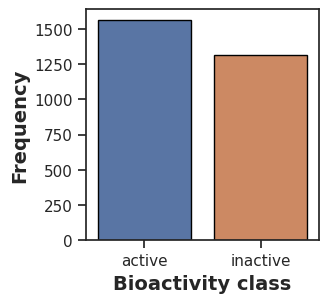

In [ ]:
plt.figure(figsize=(3,3))

sns.countplot(x='class',data=df2,edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

<Axes: xlabel='class', ylabel='pIC50'>

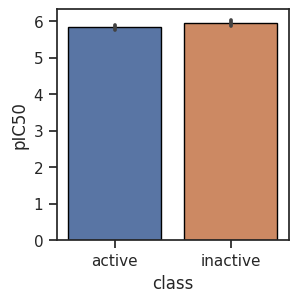

In [ ]:
plt.figure(figsize=(3,3))

sns.barplot(x='class',y='pIC50',data=df2,edgecolor='black')

### **Scatter plot of MW versus LogP**
It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

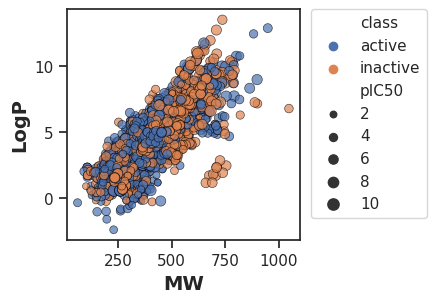

In [ ]:
plt.figure(figsize=(3, 3))

sns.scatterplot(x='MW', y='LogP', data=df2, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0, 0.5, 'pIC50 value')

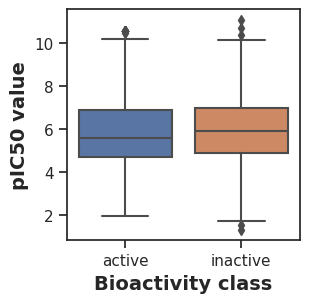

In [ ]:
# Box plots
# pIC50 value
plt.figure(figsize=(3, 3))

sns.boxplot(x = 'class', y = 'pIC50', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

### **Statistical analysis | Mann-Whitney U Test**
Mann-Whitney U test, also known as Wilcoxon rank-sum test, is a non-parametric statistical test used to compare two independent samples to determine if they are statistically significantly different from each other. It is used when the assumptions of a parametric test like t-test are not met, such as when the data is not normally distributed or when the variances of the two samples are not equal.

In [ ]:
def mannwhitney(descriptor, verbose=False):

  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df_2 = df2[selection]
  active = df_2[df_2['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df_2 = df2[selection]
  inactive = df_2[df_2['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  
  return results

In [ ]:
mannwhitney('pIC50')

Descriptor  Statistics         p  alpha                      Interpretation
0      pIC50    968084.5  0.008619   0.05  Different distribution (reject H0)

### **Box plot | MW**

Text(0, 0.5, 'MW')

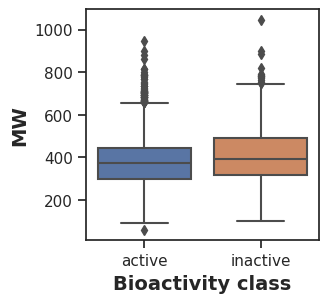

In [ ]:
plt.figure(figsize=(3, 3))

sns.boxplot(x = 'class', y = 'MW', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('MW')

Descriptor  Statistics             p  alpha  \
0         MW    917538.0  9.330828e-07   0.05   

                       Interpretation  
0  Different distribution (reject H0)

### **Box plot | LogP**

Text(0, 0.5, 'LogP')

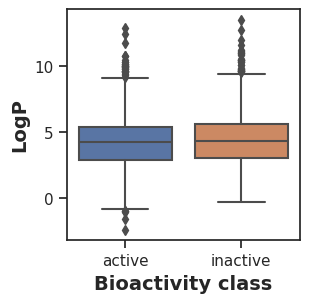

In [ ]:
plt.figure(figsize=(3, 3))

sns.boxplot(x = 'class', y = 'LogP', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('LogP')

Descriptor  Statistics         p  alpha                      Interpretation
0       LogP    964444.0  0.005257   0.05  Different distribution (reject H0)

### **Box_plot | NumHDonors**

Text(0, 0.5, 'NumHDonors')

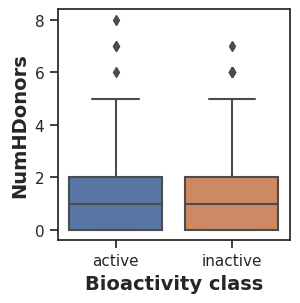

In [ ]:
plt.figure(figsize=(3, 3))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('NumHDonors')

Descriptor  Statistics         p  alpha                      Interpretation
0  NumHDonors    950993.0  0.000346   0.05  Different distribution (reject H0)

### **Box_plot | NumHAcceptors**

Text(0, 0.5, 'NumHAcceptors')

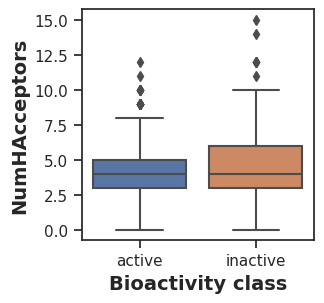

In [ ]:
plt.figure(figsize=(3, 3))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('NumHAcceptors')

Descriptor  Statistics         p  alpha  \
0  NumHAcceptors    971863.0  0.012535   0.05   

                       Interpretation  
0  Different distribution (reject H0)

### **tation of Statistical Results**
**Box Plots**

**pIC50 values**

Taking a look at pIC50 values, the actives and inactives displayed *statistically significant difference*, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

Lipinski's descriptors
All of the 4 Lipinski's descriptors exhibited **statistically significant difference** between the actives and inactives.